### Prompt Chaining In LangGraph
#### Working of Prompt Chaining
- Defining The Task
- Create Nodes
- Establish Edges
- Execute The Graph
- Iterate if Needed

#### Benifits of Chaining
- Improved Context Management
- Modularity
- Debugging
- Complex Reasoning

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [4]:
from langchain_groq import ChatGroq

model = ChatGroq(model="qwen-qwq-32b")
model.invoke("Hello, chat how are you?")

AIMessage(content='\n<think>\nOkay, the user greeted me with "Hello, chat how are you?" I should respond politely.\n\nI need to make sure I follow the guidelines: be friendly, offer assistance, and keep it natural.\n\nLet me start with a greeting, mention I\'m here to help, and ask how I can assist them today. Keep it simple and conversational.\n</think>\n\nHello! I\'m just a language model, so I don\'t have feelings, but I\'m here and ready to help you however I can! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 112, 'prompt_tokens': 17, 'total_tokens': 129, 'completion_time': 0.276111443, 'prompt_time': 0.003470009, 'queue_time': 0.434039326, 'total_time': 0.279581452}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_98b01f25b2', 'finish_reason': 'stop', 'logprobs': None}, id='run--07f67c6e-6b33-4d13-b203-64e5554562bb-0', usage_metadata={'input_tokens': 17, 'output_tokens': 112, 'total_tokens': 129})

In [5]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image ,display

In [6]:
### Defining Graph States

class State(TypedDict):
    topic:str
    story:str
    improved_story:str
    final_story:str

In [7]:
### Defining Nodes

def generate_story(state: State) -> State:
    msg = model.invoke(f"Generate a story about {state['topic']}")
    return {"story": msg.content}

def check_conflict(state: State):
    if "?" in state["story"] or "!" in state["story"]:
        return "Fail"
    return "Pass"

def imporove_story(state: State):
    msg = model.invoke(f"Improve this story: {state['story']}")
    return {"improved_story": msg.content}

def polish_story(state: State):
    msg = model.invoke(f"Add an unexpected twist to this story premise: {state['improved_story']}")
    return {"final_story": msg.content}

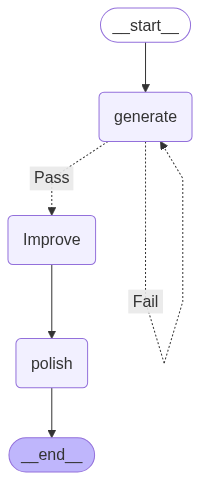

In [8]:
### Building the Graph

graph = StateGraph(State)

### Adding Nodes to the Graph
graph.add_node("generate", generate_story)
graph.add_node("Improve", imporove_story)
graph.add_node("polish", polish_story)

### Adding Edges to the Graph
graph.add_edge(START, "generate")
graph.add_conditional_edges("generate", check_conflict, {'Pass': "Improve", 'Fail': 'generate'})
graph.add_edge("Improve", "polish")
graph.add_edge("polish", END)

### Compile The Graph
compiled_graph = graph.compile()

### Running the Graph
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [9]:
### Invoke The Graph
state = {"topic": "A brave King and his loyal knight"}
final_state = compiled_graph.invoke(state)
final_state

{'topic': 'A brave King and his loyal knight',
 'story': "\n<think>\nOkay, the user wants a story about a brave king and his loyal knight. Let me start by setting up the main characters. Maybe the king is not just brave but also wise, to add depth. The loyal knight should have a strong bond with the king, perhaps they've been through battles together.\n\nI need a setting. A medieval kingdom sounds right. Maybe name the kingdom something like Eldoria to give it a regal feel. The story should have a conflict. Classic choices are an external threat, like an invading army or a dark force. Let's go with an invading force led by a rival king, but maybe add a magical element to make it more interesting, like a curse.\n\nThe plot could start with the kingdom being threatened, showing the king's bravery in leading his army. Introduce the loyal knight, Sir Godric, who is steadfast. They face a tough battle where the king gets injured, leading to a curse that weakens the kingdom. The knight must 

In [10]:
print("Improved Story")
print(final_state["improved_story"])
print("Polished Story")
print(final_state["final_story"])

Improved Story

<think>
Okay, the user wants to improve their story about a brave king and his loyal knight. Let me start by understanding the original query. The initial story is well-structured, but maybe it can be more engaging through deeper character development, richer descriptions, and heightened emotional stakes. 

First, the title, "The Crown and the Blade," is strong, but I can make it even more evocative. Maybe adding a subtitle or a more poetic title. 

Looking at the characters: King Alden and Sir Godric need more depth. Perhaps their past interactions could show their bond beyond just battle. Maybe a scene where Alden mentors Godric, highlighting their mutual respect. The antagonist Prince Voryn could be more than just a rival; maybe there's personal history between him and Alden to add complexity.

The battle scene could use more vivid imagery. Instead of just saying the battle was brutal, describe the elements: the ashen storms, the clash of steel, the king's leadership